In [1]:
%matplotlib notebook
from functools import partial as _partial

import numpy as np
import scipy.optimize as scyopt
import scipy.stats as scystat
from sklearn.datasets import make_regression as _create_data
# import gpy
import matplotlib.pyplot as mplt
from matplotlib.animation import FuncAnimation
import ipywidgets

mplt.rcParams.update({
    'font.size':10, 'axes.grid': True, 'grid.alpha': 0.5,
    'grid.linestyle': '--', 'grid.linewidth': 1, 'lines.linewidth': 2})

# Introduction: Multivariate Gaussian

The multivariate gaussian is the extension of the gaussian distribution to higher dimensions. It can be used to model the joint probability distribution of $N$ random variables $y_i$, which may be thought of as a vector in $\vect{y}\in \mathbb{R}^N$, : 

$$\vect{y} \sim \mathcal{N}(\vect{\mu}, \vect{\Sigma}) = \frac{1}{\sqrt{(2\pi)^N|\vect{\Sigma}|}}\exp\left(-\frac12(\vect{y}-\vect{\mu})^T\vect{\Sigma}^{-1}(\vect{y}-\vect{\mu})\right)$$

This distribution is completely characterized by the vector mean $\vect{\mu}\in\mathbb{R}^N$ and the correlation matrix $\vect{\Sigma}\in\mathbb{R}^N\times\mathbb{R}^N$.

<IPython.core.display.Javascript object>


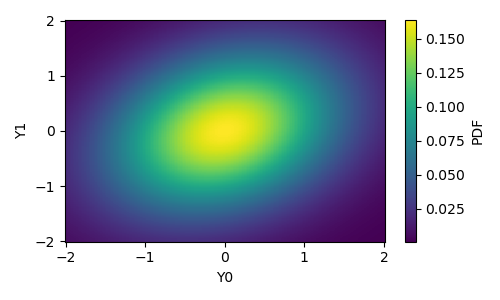

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [6]:
fig, ax = mplt.subplots(1, 1, figsize=(5, 3))
ax.set_ylabel('Y1')
ax.set_xlabel('Y0')
ax.grid(False)

# Define the grid of x and y values
y1 = np.linspace(-2, 2, 200)
y1, y2 = np.meshgrid(y1, y1)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    z = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    z *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))

    surf.set_array(z)
    surf.set_clim([z.min(), z.max()])
    fig.tight_layout()

## Gaussian distributions are closed under important operations:

### Marginalization:

Marginalization is the process of integrating out some variables of the gaussian distribution and only looking at some of them. 

Consider the join distribution of variables $\vect{x}$ and $\vect{y}$:

$$\begin{pmatrix}\vect{x} \\ \vect{y}\end{pmatrix} \sim
\mathcal{N}\left(
    \begin{pmatrix}\vect{\mu_x} \\ \vect{\mu_y}\end{pmatrix},
    \begin{pmatrix}\vect{\Sigma_{xx}} & \vect{\Sigma_{xy}}\\ \vect{\Sigma_{xy}}^T & \vect{\Sigma_{yy}}\end{pmatrix}\right) $$

If we are interested only on variable $\vect{x}$ we can integrate out variable $\vect{y}$:

$$\vect{x} \sim \int\,\mathrm{d}\vect{y}P(\vect{x},\vect{y}) = \mathcal{N}\left(\vect{\mu_x}, \vect{\Sigma_{xx}}\right)$$

where we notice that not only the result is gaussian, but that all the correlation terms between $\vect{x}$ and $\vect{y}$ does not appear on the final result. This means that we could have indefinetly many gaussian-distributed correlated variables, but if we are only interested in a few of them, we don't need to care to all the other correlation terms.

We can see this more clearly in the following 2D example, where we notice that varying the correlation does not change the dixtribution of $x$ on the right:

<IPython.core.display.Javascript object>


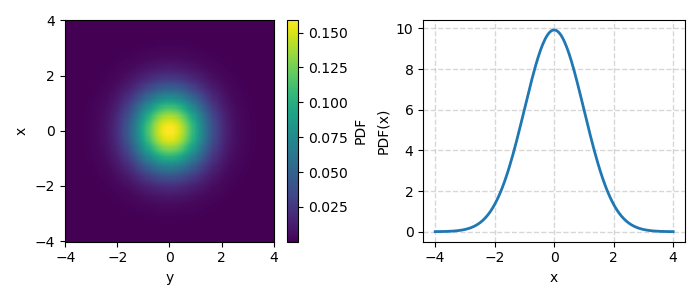

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [9]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ay.set_xlabel('x')
ay.set_ylabel('PDF(x)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    pdfx = np.trapz(pdf, axis=0)
    
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()

    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.tight_layout()

### Conditioning:

Conditioning is the process of fixing a subset of the random variables and looking at the distribution of the other variables.

Consider the same setup defined above. The conditional probability of $\vect{x}$ when $\vect{y}$ is fixed is given by:

$$P(\vect{x}|\vect{y}=\vect{a}) = \mathcal{N}\left(\vect{\mu_x} + \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}(\vect{a}-\vect{\mu_y}),\,\, \vect{\Sigma_{xx}} - \vect{\Sigma_{xy}}\vect{\Sigma_{yy}}^{-1}\vect{\Sigma_{xy}}^T \right)$$

Note how in this case both, the mean and variance of the posterior on $\vect{x}$ are changed.

The example below show this fact for a 2D case:

<IPython.core.display.Javascript object>


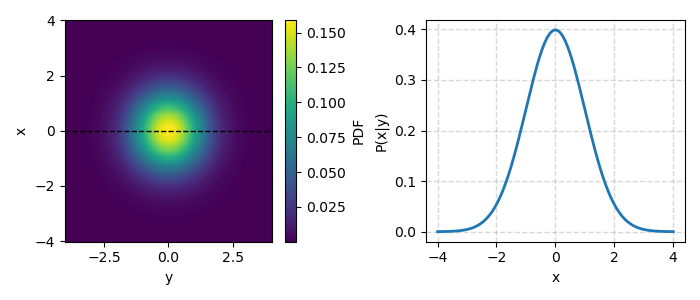

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Float…

In [11]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('x')
ax.set_xlabel('y')
ax.grid(False)
ay.set_xlabel('x')
ay.set_ylabel('P(x|y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlin = ax.axline((0, 0), (1, 0), lw=1, ls='--', color='k')
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01), y0=(-4, 4, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    sigx = cov[0, 0] - correlation**2/cov[1, 1]
    mux = 0 + correlation/cov[1, 1]*(y0-0)
    pdfx = np.exp(-1/2 * (y-mux)**2/sigx**2)
    pdfx /= np.sqrt(2 * np.pi * sigx**2)
    lin.set_data(y, pdfx)
    ay.relim()
    ay.autoscale_view()
    
    global hlin
    hlin.remove()
    hlin = ax.axline((0, y0), (1, y0), lw=1, ls='--', color='k')
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    fig.tight_layout()

### Affine Transformation

An affine transformation of a random variable $\vect{x}\in\mathbb{R}^N$ into another random variable $\vect{y}\in\mathbb{R}^M$ is defined by:

$$ \vect{y} = \vect{c} + \vect{B}\vect{x}$$

where $\vect{c} \in \mathbb{R}^M$ and $\vect{B}\in\mathbb{R}^M\times\mathbb{R}^N$ are constants.

Given that $\vect{x}$ is distributed normally, $\vect{x}\sim\mathcal{N}(\vect{\mu_x},\, \vect{\Sigma})$, then $\vect{y}$ will also be distributed normally:

$\vect{y}\sim\mathcal{N}(\vect{c} + \vect{B}\vect{\mu_x},\, \vect{B}\vect{\Sigma}\vect{B}^T)$


As an example, let's look to the 2D case below, where $\vect{B}=(a, b)$, with $a,b\in\mathbb{R}$:

<IPython.core.display.Javascript object>


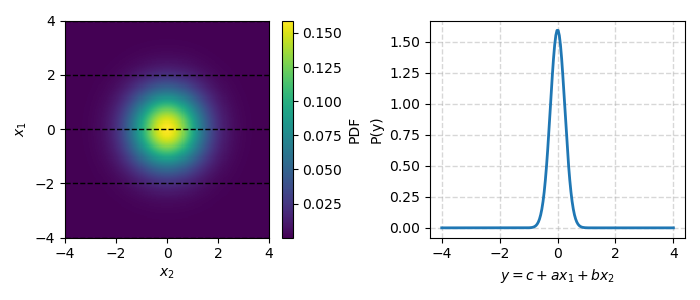

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Float…

In [13]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ay.set_xlabel('$y = c + ax_1 + bx_2$')
ay.set_ylabel('P(y)')

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
hlins = [
    ax.axline((0, 0), slope=0, lw=1, ls='--', color='k')
    for yi in np.linspace(-8, 8, 17)]
lin, = ay.plot(y, y)
fig.colorbar(surf, label='PDF')

@ipywidgets.interact
def plot_gauss(
        correlation=(-0.99, 0.99, 0.01), a=(-10, 10, 0.01), b=(0.01, 1, 0.01),
        c=(-4, 4, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    pdf = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    pdf *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))
    
    B = np.array([a, b])
    sigy = B @ cov @ B.T
    muy = c + B @ np.array([0, 0])
    pdfy = np.exp(-1/2 * (y-muy)**2/sigy**2)
    pdfy /= np.sqrt(2 * np.pi * sigy**2)
    lin.set_data(y, pdfy)
    ay.relim()
    ay.autoscale_view()
    
    global hlins
    _ = [h.remove() for h in hlins]
    hlins = [
        ax.axline((0, (yi-c)/b), slope=-a/b, lw=1, ls='--', color='k')
        for yi in np.linspace(-8, 8, 17)]
    surf.set_array(pdf)
    surf.set_clim([pdf.min(), pdf.max()])
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    fig.tight_layout()

### Product of two distributions

The multivariate gaussian is also closed under multiplication. 

given two normal distributions

$$\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\quad\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2})$$

the product between them is also a gaussian:

$$\mathcal{N}(\vect{\mu_3},\, \vect{\Sigma_3})=\mathcal{N}(\vect{\mu_1},\, \vect{\Sigma_1})\mathcal{N}(\vect{\mu_2},\, \vect{\Sigma_2})$$

where

$$\vect{\Sigma_3} = \vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\Sigma_2}$$
$$\vect{\mu_3} = 
\vect{\Sigma_2}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_1} + 
\vect{\Sigma_1}\left(\vect{\Sigma_1} + \vect{\Sigma_2}\right)^{-1}\vect{\mu_2}$$

Let's again look at a 2D example:

<IPython.core.display.Javascript object>


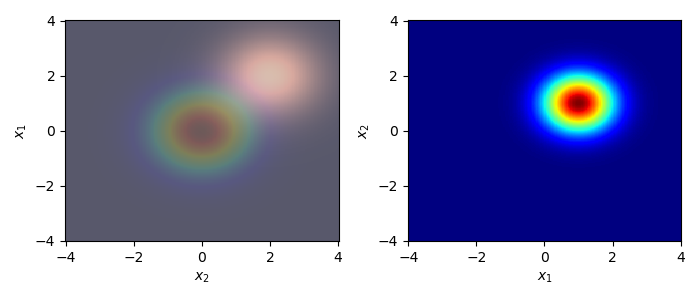

In [15]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_2$')
ax.grid(False)
ay.set_xlabel('$x_1$')
ay.set_ylabel('$x_2$')
ay.grid(False)

# Define the grid of x and y values
y = np.linspace(-4, 4, 200)
y1, y2 = np.meshgrid(y, y)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

surf1 = ax.pcolormesh(y1, y2, y2, alpha=0.3, cmap='jet')
surf2 = ax.pcolormesh(y1, y2, y2, alpha=0.5, cmap='copper')
surf3 = ay.pcolormesh(y1, y2, y2, alpha=1, cmap='jet')

def plot_gauss(
        corr1=0, mu1_1=0, mu1_2=0,
        corr2=0, mu2_1=0, mu2_2=0,
        calculated=False):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    mu1 = np.array([mu1_1, mu1_2])
    cov1 = np.eye(2)
    cov1[0, 1] = corr1
    cov1[1, 0] = corr1

    mu2 = np.array([mu2_1, mu2_2])
    cov2 = np.eye(2)
    cov2[0, 1] = corr2
    cov2[1, 0] = corr2

    inv = np.linalg.inv(cov1 + cov2)
    cov3 = cov1 @ inv @ cov2
    mu3 = cov2 @ inv @ mu1 + cov1 @ inv @ mu2
    
    # Calculate the inverse of the covariance matrix
    cov1i = np.linalg.inv(cov1)
    cov2i = np.linalg.inv(cov2)
    cov3i = np.linalg.inv(cov3)

    # Calculate the multivariate Gaussian distribution
    pdf1 = np.exp(-1/2 * np.sum((pos-mu1) @ cov1i * (pos-mu1), axis=-1))
    pdf1 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov1))
    
    pdf2 = np.exp(-1/2 * np.sum((pos-mu2) @ cov2i * (pos-mu2), axis=-1))
    pdf2 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov2))
    
    if calculated:
        pdf3 = np.exp(-1/2 * np.sum((pos-mu3) @ cov3i * (pos-mu3), axis=-1))
        pdf3 *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov3))
        surf3.set_cmap('copper')
    else:
        pdf3 = pdf1 * pdf2
        surf3.set_cmap('jet')
    
    surf1.set_array(pdf1)
    surf1.set_clim([pdf1.min(), pdf1.max()])

    surf2.set_array(pdf2)
    surf2.set_clim([pdf2.min(), pdf2.max()])

    surf3.set_array(pdf3)
    surf3.set_clim([pdf3.min(), pdf3.max()])

    fig.tight_layout()
    
wid = ipywidgets.interactive(
    plot_gauss,
    corr1=(-0.99, 0.99, 0.01), mu1_1=(-4, 4, 0.01), mu1_2=(-4, 4, 0.01),
    corr2=(-0.99, 0.99, 0.01), mu2_1=(-4, 4, 0.01), mu2_2=(-4, 4, 0.01),
    calculated=False)

controls = ipywidgets.HBox(
    wid.children[:-1],
    layout=ipywidgets.Layout(flex_flow='row wrap'))
output = wid.children[-1]
display(ipywidgets.VBox([controls, output]))

Note that all the properties described above can be calculated using very basic linear algebra, which implies that almost everythin involving gaussians is very easy and fast to evaluate.

These properties are the main reason gaussians are used everywhere in statistics, mainly in Bayesian Inference.

What generally requires integration in a high dimensional space with other distributions can be accomplished with a few matrix multiplications when gaussians are involved. 

# Bayes Theorem and Bayesian Inference

$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{{#1}}}}}$

Suppose we have a physical quantity $y$ whose value we don't know but we think it is distributed normally with $\sigma=3$. Since we don't know the value, we assume $\mu=0$. The PDF of this variable is given by:

$$P(y|\mu=0,\sigma=3) = \mathcal{N}(0,3) = \frac{1}{3\sqrt{2\pi}}\exp\left(-\frac12\frac{y^2}{3^2}\right)$$

<IPython.core.display.Javascript object>


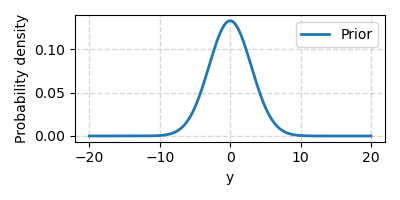

In [16]:
# Code made by chatgpt with a few modifications

# Define the prior mean and standard deviation
mu_0 = 0
sigma_0 = 3

# Define a range of X values
X = np.linspace(-20, 20, 10000)

# Calculate the prior PDF
prior_pdf = scystat.norm.pdf(X, mu_0, sigma_0)

# Plot the prior PDF
fig, ax = mplt.subplots(1, 1, figsize=(4, 2))
ax.plot(X, prior_pdf, label='Prior')
ax.set_xlabel('y')
ax.set_ylabel('Probability density')
ax.legend(loc='best')
fig.tight_layout()
fig.show()

Now suppose we make a measurement $y_0$ of this quantity and the value is $5$. The measurement procedure has an uncertainty whose standard deviation is $1$. We could say that the result of the measurement also is a gaussian:

$$P(y_0|y, \mu_0=5, \sigma_0=1) = \mathcal{N}(5, 1) = \frac{1}{1\sqrt{2\pi}}\exp\left(-\frac12\frac{(y_0-5)^2}{1^2}\right)$$

we can use Bayes Theorem to update our beliefs given this new information:

$$P(y|y_0) = \frac{P(y_0|y)P(y)}{P(y_0)}$$

where :
 - $P(y|y_0)$ is called the posterior, because it represents our updated beliefs on $y$ after the measurement;
 - $P(y)=P(y|\mu,\sigma)$ is our prior assumption;
 - $P(y_0|y)$ called likelihood, which in our case is the measurement information;
 - $P(y_0)$ is the probability of having measured $y_0$ (marginal likelihood) which here we can consider just as a normalization constant

In [2]:
def animate_bayes(frames, mu_x, sigma_x, x, prior):
    post_pdf = prior.copy()

    # Plot the prior PDF
    fig, ax = mplt.subplots(1, 1, figsize=(4, 2))
    ax.plot(X, prior, label='Prior')
    ax.set_xlabel('y')
    ax.set_ylabel('Probability density')
    ax.legend(loc='best')
    fig.tight_layout()

    line, = ax.plot([0], [0])
    lines = ax.plot([0], np.array([[0]]*len(frames)).T)
    for l in lines:
        l.set_visible(False)
    def update(i, post):
        mux = mu_x[i]
        sigx = sigma_x[i]
        # Calculate the likelihood PDF
        likelihood_pdf = scystat.norm.pdf(x, mux, sigx)

        # Plot the likelihood PDF
        lines[i].set_data(x, likelihood_pdf)
        lines[i].set_label(f'y{i:d}~N({mux:.1f},{sigx:.1f})')
        lines[i].set_visible(True)

        # Multiply the prior PDF and the likelihood PDF to 
        # get the unnormalized posterior PDF
        post *= likelihood_pdf

        # Normalize the unnormalized posterior PDF
        norm_constant = np.trapz(post, x)
        post /= norm_constant

        # Plot the posterior PDF
        line.set_data(x, post)
        line.set_label(f'Posterior {i:d}')
        ax.legend(loc='best', fontsize='x-small')
        ax.relim()
        ax.autoscale_view()
        fig.tight_layout()
        return []

    return FuncAnimation(
        fig, update, fargs=(post_pdf, ), frames=frames,
        repeat=False, repeat_delay=2, interval=1000, init_func=lambda: [])

In [3]:
# Define the measurement mean and standard deviation
mu_x = [5, 1, 3, 2, 3.5]
sigma_x = [1, 4, 1.5, 2, 0.5]
frames = list(range(len(mu_x)))

<IPython.core.display.Javascript object>


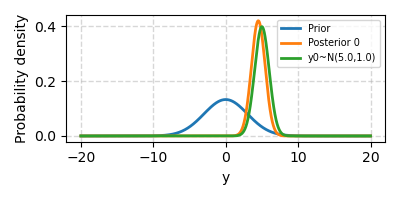

In [9]:
anim = animate_bayes(frames[:1], mu_x, sigma_x, X, prior_pdf)

If more data is measured our beliefs can be updated considering the previous posterior distribution as prior:

$$P(y|\{y_0,y_1\}) = \frac{P(y_1|y)P(y|y_0)}{P(y_1)} = \frac{P(y_1|y)P(y_0|y)P(y)}{P(y_1)P(y_0)}$$

This process can be repeated indefinetly considering new measurements are made:

$$P(y|\mathcal{D}) = \frac{\prod_\mathcal{D}P(y_i|y)}{\prod_\mathcal{D}P(y_i)}P(y), \quad \mathcal{D}=\{y_i| i=0..N\} \quad\mathrm{and}\quad y_i \sim \mathcal{N}(\mu_i, \sigma_i)$$

<IPython.core.display.Javascript object>


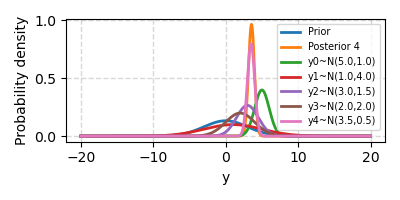

In [10]:
anim = animate_bayes(frames, mu_x, sigma_x, X, prior_pdf)

It is worth noticing that the final posterior does not depend on the order of the new data:

<IPython.core.display.Javascript object>


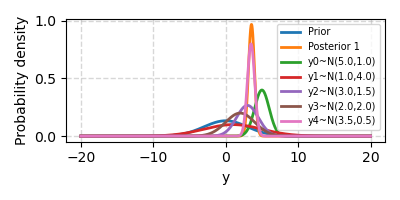

In [13]:
anim2 = animate_bayes(
    np.random.permutation(frames), mu_x, sigma_x, X, prior_pdf)

# Using Bayes theorem for parametric fitting

In [4]:
def feature_func_polynomial(x, num_features=2):
    """."""
    return x.ravel()[:, None]**(np.arange(num_features)[None, :])


feature_func_linear = _partial(feature_func_polynomial, num_features=2)


def feature_func_sines(x, num_freqs=6):
    mat = np.empty((x.size, num_freqs*2-1), dtype=float)
    x_mat = x.ravel()[:, None] * np.arange(num_freqs)[None, :]
    mat[:, :num_freqs] = np.sin(x_mat)
    mat[:, num_freqs:] = np.cos(x_mat[:, 1:])
    return mat


def feature_func_gauss(x, mean_range=6, sigma=1):
    means = np.arange(-mean_range, mean_range+1)
    mat = np.exp(-(x.ravel()[:, None]-means[None, :])**2/2/sigma**2)
    return mat


def feature_func_steps(x, step_range=6):
    steps = np.arange(-step_range, step_range+1)
    mat = (x.ravel()[:, None] > steps[None, :])*2 - 1
    return mat


def parametric_bayesian_regression(
        x, x_data, y_data, mu_prior=None, sigma_prior=None, sigma_err=1,
        feature_func=None):
    if feature_func is None:
        feature_func = feature_func_linear
    
    phi_x = feature_func(x)
    phi_data = feature_func(x_data)
    num_features = phi_data.shape[1]
    if mu_prior is None:
        mu_prior = np.zeros((num_features, 1), dtype=float)
    elif isinstance(mu_prior, (int, np.int_, np.float_, float)):
        mu_prior = mu_prior * np.ones((num_features, 1))
    elif isinstance(mu_prior, (np.ndarray, list, tuple)):
        mu_prior = np.array(mu_prior)
        if mu_prior.ndim == 1:
            mu_prior.shape = (mu_prior.size, 1)
    
    if mu_prior.shape[0] != num_features:
        raise ValueError('Wrong value for mu_prior')

    if sigma_prior is None:
        sigma_prior = np.eye(num_features)
    elif isinstance(sigma_prior, (int, np.int_, np.float_, float)):
        sigma_prior = sigma_prior * np.eye(num_features)
    elif isinstance(sigma_prior, (np.ndarray, list, tuple)):
        sigma_prior = np.array(sigma_prior)
        if sigma_prior.ndim == 1:
            sigma_prior = np.diag(sigma_prior)
    
    shape = sigma_prior.shape
    if not shape[0] == shape[1] == num_features:
        raise ValueError('Wrong value for sigma_prior')

    muf_prior = phi_x @ mu_prior
    sigmaf_prior = phi_x @ sigma_prior @ phi_x.T  # kxx

    muf_data = phi_data @ mu_prior
    sigmaf_data = phi_data @ sigma_prior @ phi_data.T  # kXX
    err_data = y_data[:, None]-muf_data

    if x_data.size < num_features:
        # this method has the advantage of easy interpretation of a 
        # joint distribution between measured data and infered data and also
        # shows more clearly the importance of the kernel function
        kXXi = np.linalg.inv(sigmaf_data + np.eye(x_data.size)*sigma_err**2)
        B = sigma_prior @ phi_data.T
        mu_post = mu_prior + B @ kXXi @ err_data
        sigma_post = sigma_prior - B @ kXXi @ B.T
    else:
        # this method is optimized for larger sets of data, due to the fact 
        # that the matrix inversion is done in the parameters covariance 
        # matrix, which is generally smaller than the data matrix.
        A = phi_data.T @ phi_data/sigma_err**2 + np.linalg.inv(sigma_prior)
        sigma_post = np.linalg.inv(A)
        print()
        mu_post = mu_prior + 1/sigma_err**2*sigma_post @ phi_data.T @ err_data
    
    muf_post = phi_x @ mu_post
    sigmaf_post = phi_x @ sigma_post @ phi_x.T
    return dict(
        feature_func=feature_func,
        prior=scystat.multivariate_normal(mu_prior.ravel(), sigma_prior),
        post=scystat.multivariate_normal(mu_post.ravel(), sigma_post))

def animate_regression(
        x, x_data, y_data, mu_prior=None, sigma_prior=None, sigma_err=1,
        feature_func=None, w_truth=None):

    reg = parametric_bayesian_regression(
        x, x_data, y_data, mu_prior, sigma_prior, sigma_err,
        feature_func)
    dist = reg['prior']
    phix = reg['feature_func'](x)
    muf = phix @ dist.mean
    stdf = phix @ dist.cov_object.covariance @ phix.T
    stdf = np.sqrt(np.diag(stdf))
    
    is2d = len(dist.mean) == 2
    if is2d:
        fig, (ax, ay) = mplt.subplots(1, 2, figsize=(9, 4))

        wgrid = np.linspace(-6, 6, 100)
        w1grid, w2grid = np.meshgrid(wgrid, wgrid)
        pos = np.empty(w1grid.shape + (2, ))
        pos[:, :, 0] = w1grid
        pos[:, :, 1] = w2grid
    else:
        fig, ay = mplt.subplots(1, 1, figsize=(7, 4))
   
    def animate(frame):
        reg = parametric_bayesian_regression(
            x, x_data[:frame], y_data[:frame], mu_prior, sigma_prior,
            sigma_err, feature_func)
        dist = reg['post']
        if is2d:
            pdf = dist.pdf(pos)
            ax.clear()
            ax.grid(False)
            levels = pdf.max()*np.array([0.1, 0.4, 0.7, 0.95])
            ax.contour(
                w1grid, w2grid, pdf, cmap='copper', levels=levels)
            ax.pcolormesh(w1grid, w2grid, pdf, cmap='copper', alpha=0.5)
            if w_truth is not None:
                ax.plot(*w_truth, 'ko', label='Truth')

            ax.legend(loc='best')
            ax.set_xlabel('w1 (intercept)')
            ax.set_ylabel('w2 (angular coeff)')
            ax.set_xlim([-3, 3])
            ax.set_ylim([-3, 3])
            
        muf = phix @ dist.mean
        stdf = phix @ dist.cov_object.covariance @ phix.T
        stdf = np.sqrt(np.diag(stdf))
        
        ay.clear()
        ay.set_xlabel('x')
        ay.set_ylabel('y = f(x) + epsilon')
        if w_truth is not None:
            ay.plot(x, phix@w_truth, 'k--', label='Truth')
        
        ay.plot(x, muf, label='expected f(x)')
        ay.fill_between(
            x, muf+1.96*stdf, muf-1.96*stdf, color='C0', alpha=0.2,
            label='95% confidence')
        ay.errorbar(
            x_data[:frame], y_data[:frame], yerr=sigma_err, linestyle='',
            marker='o', color='k', barsabove=True, label='Data')
        ay.legend(loc='best')
        fig.tight_layout()
        return []
    
#     return animate(0)
    return FuncAnimation(
        fig, animate, frames=np.arange(0, x_data.size+1),
        repeat=True, repeat_delay=1000, interval=1000)


def animate_distribution(x, mu, sigma, feature_func):
    """."""
    mu = mu.ravel()
    frames = np.arange(40)
    dist = scystat.multivariate_normal(mu, sigma)
    phix = feature_func(x)

    muf = phix @ dist.mean
    stdf = phix @ dist.cov_object.covariance @ phix.T
    stdf = np.sqrt(np.diag(stdf))

    lev_smpl = -2*np.log([0.9, 0.7, 0.5, 0.36])
    
    N = phix.shape[1]
    nvec = lev_smpl.size
#     # Create a random unitary matrix in N-dim to rotate the vector v around it
#     Q, _ = np.linalg.qr(np.random.randn(N, N))
#     Q /= np.linalg.det(Q)
#     # Create a random unitary vectors in N-dim to be rotated by the animation.
#     choi = [np.random.choice(N, 2, replace=False) for _ in range(nvec)]
#     v = Q[:, choi]

    v = np.random.randn(N, nvec, 2)  # create 2 lists of nvec random vectors
    v[..., 0] /= np.linalg.norm(v[..., 0], axis=0)  # normalize first list
    # make ith vector of second list orthogonal to ith vector of first list:
    v[0, :, 1] = -np.sum(v[1:, :, 0]*v[1:, :, 1], axis=0)/v[0, :, 0]
    v[..., 1] /= np.linalg.norm(v[..., 1], axis=0)  # normalize second list

    # Create transformation matrix from v to w
    lamb, D = np.linalg.eigh(sigma)
    Lambsqrt = np.diag(np.sqrt(lamb))

    # Create the parametrized rotation matrix:
    theta = 2*np.pi * 0/frames.size
    R = np.eye(2, dtype=float)
    R = ((np.cos(theta), np.sin(theta)), (-np.sin(theta), np.cos(theta)))
    # Rotate and transfor the vector
    vr = v @ R
    vr = vr[:, :, 0] * lev_smpl[None, :]
    wr = mu[:, None] + D @ Lambsqrt @ vr
    
    is2d = len(dist.mean) == 2
    if is2d:
        fig, (ax, ay) = mplt.subplots(1, 2, figsize=(9, 4))

        sigm = max(*np.diag(sigma), 0.5)
        lims1 = mu[0] - 2.1*sigm, mu[0] + 2.1*sigm
        lims2 = mu[1] - 2.1*sigm, mu[1] + 2.1*sigm
        
        w1grid, w2grid = np.meshgrid(
            np.linspace(*lims1, 100), np.linspace(*lims2, 100))
        pos = np.empty(w1grid.shape + (2, ))
        pos[:, :, 0] = w1grid
        pos[:, :, 1] = w2grid
        pdf = dist.pdf(pos)
        lev_cont = pdf.max()*np.array([0.1, 0.4, 0.7, 0.95])
    else:
        fig, (ax, ay) = mplt.subplots(2, 1, figsize=(7, 5), sharex=True)
        ax.plot(x, phix, 'k', lw=1)
        ax.set_ylabel('Basis Functions')

   
    def animate(frame):
        # Create the parametrized rotation matrix:
        theta = 2*np.pi * frame/frames.size
        R = np.eye(2, dtype=float)
        R = ((np.cos(theta), np.sin(theta)), (-np.sin(theta), np.cos(theta)))
        # Rotate and transfor the vector
        vr = v @ R
        vr = vr[:, :, 0] * lev_smpl[None, :]
        wr = mu[:, None] + D @ Lambsqrt @ vr

        if is2d:
            ax.clear()
            ax.grid(False)
            ax.contour(
                w1grid, w2grid, pdf, cmap='copper', levels=lev_cont)
            ax.pcolormesh(
                w1grid, w2grid, pdf, cmap='copper', alpha=0.5)
            for i, dum in enumerate(wr.T, 1):
                ax.plot(*dum, 'o', color=f'C{i:d}')
            ax.set_xlabel('w1 (intercept)')
            ax.set_ylabel('w2 (angular coeff)')
            sigm = max(*np.diag(sigma), 0.5)
            ax.set_xlim(lims1)
            ax.set_ylim(lims2)
            
        muf = phix @ dist.mean
        stdf = phix @ dist.cov_object.covariance @ phix.T
        stdf = np.sqrt(np.diag(stdf))
        
        ay.clear()
        ay.set_xlabel('x')
        ay.set_ylabel('y = f(x) + epsilon')
        
        ay.plot(x, muf, label='expected f(x)')
        ay.fill_between(
            x, muf+1.96*stdf, muf-1.96*stdf, color='C0', alpha=0.2,
            label='95% confidence')
        lines = [
            ay.plot(
                x, xd, '--', color=f'C{i:d}',lw=1)[0]
            for i, xd in enumerate((phix @ wr).T, 1)]
        lines[0].set_label('samples')

        ay.legend(loc='lower center', bbox_to_anchor=(0.5, 0))
        fig.tight_layout()
        return []
    
#     return animate(0)
    return FuncAnimation(
        fig, animate, frames=frames,
        repeat=True, repeat_delay=20, interval=20)

As an example let's see how we could use the framework defined above to perform parametric regression of some curves.

First, let's start with the simple straight line model:

$$ f(x) = \omega_1 + \omega_2x = \vect{\phi}(x)^T\vect{\omega}$$

where $\vect{\omega} \in \mathbb{R}^2$ is the vector of random variables we want to know more about and $\vect{\phi}(x) = (1, x)^T$. When we look this way we see that the function is a random variable defined by the affine transformation $\vect{\phi}(x)$ of $\vect{\omega}$.

Now lets assume a gaussian prior on $\vect{\omega}$:

$$ \vect{\omega} \sim \mathcal{N}\left(\vect{\bar{\omega}}, \vect{\Sigma}\right)$$

Considering that f is just a linear combination of $\vect{\omega}$, the prior on $f(x)$ is given by:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}},\,\, \vect{\phi}^T\vect{\Sigma}\vect{\phi}\right)$$

The figure below shows the general behavior of this prior:

In [23]:
# Prior on omega
feat_func = feature_func_linear
num_pts = 100
x = np.linspace(-6, 6, num_pts)
mu_prior = np.zeros((feat_func(x).shape[1], 1))
sigma_prior = 3*np.eye(mu_prior.shape[0])

In [24]:
# Made up data
w_truth = (1, 2)
num_data = 10
sigma_err = 1
x_data = (np.random.rand(num_data)-0.5)*2 * 6
phi_data = feature_func_polynomial(x_data, num_features=len(w_truth))
y_data = phi_data @ w_truth + np.random.randn(*x_data.shape)*sigma_err

In [25]:
anim = animate_distribution(x, mu_prior, sigma_prior, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [26]:
anim.repeat=False
# anim.resume()

Now, suppose that a total of $N$ measurements are performed, such that:

$$\mathcal{D} = \{(x_i, y_i)| i\in[1,N]\} = (\vect{x}, \vect{y})$$

where $y_i$ represent noisy observations of the underlying function $f(x_i)$:

$$y_i = f(x_i) + \varepsilon, \quad\mathrm{with}\quad \varepsilon \sim \mathcal{N}(0,\sigma^2)$$

This way we se that the likelyhood of all the measurements is given by:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \prod_\mathcal{D}\frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{(y_i-\vect{\phi}(x_i)^T\vect{\omega})^2}{2\sigma^2}\right)$$

Since we are considering all measurement error distributions are equally distributed (same $\sigma^2$) and gaussian. We can simplify the equation above such that:

$$P(\vect{y}|\vect{\omega}, \mathcal{D}) = \frac{1}{(2\pi)^{N/2}\sigma^N}\exp\left(-\frac{|\vect{y}-\vect{\Phi}^T\vect{\omega}|^2}{2\sigma^2}\right)$$

where we introduced the matrix $\vect{\Phi} := (\phi(x_1),...\phi(x_i),...\phi(x_N))$.

The posterior distribution can then be updated using Bayes theorem:

$$P(\vect{\omega}|\mathcal{D}) = \frac{P(\vect{y}|\vect{x},\vect{\omega})P(\vect{\omega})}{P(\vect{y}|\vect{x})} \propto
\exp\left(-\frac{1}{2\sigma^2}\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)^T\left(\vect{y}-\vect{\Phi}^T\vect{\omega}\right)\right)
\exp\left(-\frac12(\vect{\omega}-\vect{\bar{\omega}})^T\vect{\Sigma}^{-1}(\vect{\omega}-\vect{\bar{\omega}})\right)
$$

Since all distributions are gaussian, we can analytically compute the posterior by completing the squares on the equation above. After some math we see the posterior is also gaussian:

$$P(\vect{\omega}|\mathcal{D}) = \mathcal{N}(\vect{\bar{\omega}_p}, \vect{\Sigma_p}),
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=
\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}})
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

and, consequently, the posterior on $f(x)$ is also gaussian:

$$ f(x) \sim \mathcal{N}\left(\vect{\phi}^T\vect{\bar{\omega}_p},\,\, \vect{\phi}^T\vect{\Sigma_p}\vect{\phi}\right)$$

The animation below shows the process of the regression as data is measured, point by point, and how the posteriors are updated:

In [27]:
anim = animate_regression(
    x, x_data, y_data, mu_prior, sigma_prior, sigma_err,
    feature_func=feat_func, w_truth=w_truth)

<IPython.core.display.Javascript object>

In [28]:
anim.repeat = False
# anim.resume()

The animation below shows the posterior distribution and some of its samples:

In [29]:
res = parametric_bayesian_regression(
    x, x_data, y_data, mu_prior, sigma_prior, sigma_err, feature_func=feat_func)
anim = animate_distribution(
    x, res['post'].mean, res['post'].cov_object.covariance, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [30]:
anim.repeat = False
# anim.resume()

In [48]:
# Made up data
w_truth = (1, 2, -0.2, 0.02)
sigma_err = 3
x_data = np.arange(-6, 6) + 0.5
phi_data = feature_func_polynomial(x_data, num_features=len(w_truth))
y_data = phi_data @ w_truth + np.random.randn(*x_data.shape)*sigma_err

In [49]:
# Prior on omega
# feat_func = feature_func_linear
feat_func = _partial(feature_func_polynomial, num_features=4)
# feat_func = _partial(feature_func_gauss, mean_range=6)
# feat_func = _partial(feature_func_steps, step_range=6)
num_pts = 100
x = np.linspace(-6, 6, num_pts)
mu_prior = np.zeros((feat_func(x).shape[1], 1))
sigma_prior = 3*np.eye(mu_prior.shape[0])

Notice that the formalism defined above can readly be applied to any model whose basis functions are fixed. For example, in the case of a polynomial we have:

$$f(x) = \omega_0 + \omega_1x + ... + \omega_px^p = \vect{\phi}^T\vect{\omega}$$

where now $\vect{\omega}, \vect{\phi} \in \mathbb{R}^p$ with $\phi = (1, x, ..., x^p)$ and the same equations above hold.

So that we have the prior on $\vect{\omega}$ being a $p$-dimensional multivariate gaussian:

In [50]:
anim = animate_distribution(x, mu_prior, sigma_prior, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [51]:
anim.repeat=False
# anim.resume()

The regression evolution as new data comes in is shown below:

In [52]:
anim = animate_regression(
    x, x_data, y_data, mu_prior, sigma_prior, sigma_err,
    feature_func=feat_func, w_truth=w_truth)

<IPython.core.display.Javascript object>

In [53]:
anim.repeat = False
# anim.resume()

In [54]:
# Prior on omega
feat_func = _partial(feature_func_sines, num_freqs=6)
# feat_func = _partial(feature_func_gauss, mean_range=6)
# feat_func = _partial(feature_func_steps, step_range=6)
num_pts = 100
x = np.linspace(-6, 6, num_pts)
mu_prior = np.zeros((feat_func(x).shape[1], 1))
sigma_prior = 20*np.eye(mu_prior.shape[0])

The same idea also applies when the basis functions are not polynomials. For example, in case they are sines and cossines:

$$\vect{\phi} = (1, \sin(x), ..., \sin(px), \cos(x), ..., \cos(px))^T$$

We have the following prior:

In [55]:
anim = animate_distribution(x, mu_prior, sigma_prior, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [56]:
anim.repeat=False
# anim.resume()

In [57]:
anim = animate_regression(
    x, x_data, y_data, mu_prior, sigma_prior, sigma_err,
    feature_func=feat_func, w_truth=None)

<IPython.core.display.Javascript object>

In [58]:
anim.repeat = False
# anim.resume()

In [59]:
# Prior on omega
feat_func = _partial(feature_func_steps, step_range=6)
# feat_func = _partial(feature_func_gauss, mean_range=6)
num_pts = 100
x = np.linspace(-6, 6, num_pts)
mu_prior = np.zeros((feat_func(x).shape[1], 1))
sigma_prior = 20*np.eye(mu_prior.shape[0])

Discontinue functions are also an option. For example, in case they step functions:

$$\vect{\phi} = (\Theta(x-a_0),..., \Theta(x-a_p))^T, \quad \mathrm{with}\quad\{a_i\in\mathbb{R}| i\in[1,p]\}$$

We have the following prior:

In [60]:
anim = animate_distribution(x, mu_prior, sigma_prior, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [61]:
anim.repeat=False
# anim.resume()

In [62]:
anim = animate_regression(
    x, x_data, y_data, mu_prior, sigma_prior, sigma_err,
    feature_func=feat_func, w_truth=None)

<IPython.core.display.Javascript object>

In [63]:
anim.repeat = False
# anim.resume()

In [64]:
# Prior on omega
feat_func = _partial(feature_func_gauss, mean_range=6)
num_pts = 100
x = np.linspace(-6, 6, num_pts)
mu_prior = np.zeros((feat_func(x).shape[1], 1))
sigma_prior = 30*np.eye(mu_prior.shape[0])

An interesting particular case of this formalism comes when the basis functions are equally spaced gaussian functions with the same variance:

$$\vect{\phi} = (
\exp\left(-\frac{(x-a_0)^2}{2\sigma}\right),
...,
\exp\left(-\frac{(x-a_0)^2}{2\sigma}\right), 
\quad \mathrm{with}\quad
\sigma\in\mathbb{R}
\,\,\mathrm{and}\,\,
\{a_i\in\mathbb{R}| i\in[1,p]\}
\,\,\mathrm{both\,constants}$$

Note from the prior how the samples are very smooth functions:

In [65]:
anim = animate_distribution(x, mu_prior, sigma_prior, feature_func=feat_func)

<IPython.core.display.Javascript object>

In [66]:
anim.repeat=False
# anim.resume()

Another interesting feature of this set of basis functions is that the posterior tends towards the prior away from the data, since all basis functions go to zero at $\pm\infty$:

In [70]:
anim = animate_regression(
    x, x_data[2:-2], y_data[2:-2], mu_prior, sigma_prior, sigma_err,
    feature_func=feat_func, w_truth=None)

<IPython.core.display.Javascript object>

In [71]:
anim.repeat = False
# anim.resume()

To end this section on parametric fitting it is worth writting the posterior on $f(x)$ in a different manner. First recall that the posterior on $f(x)$ is given by:

$$ f(x_*) \sim \mathcal{N}\left(\vect{\phi_*}^T\vect{\bar{\omega}_p},\,\, \vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*}\right)
\quad \mathrm{with} \quad
\vect{\bar{\omega}_p}=\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\Sigma_p}\vect{\Phi}\vect{y}
\quad \mathrm{and} \quad
\vect{\Sigma_p}=\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}$$

where we introduced $x_*$ to denote the coordinate where we want to predict $f(x)$ and $\vect{\phi_*}=\vect{\phi}(x_*)$
Using an matrix identity, we can rewrite 

$$
\vect{\phi_*}^T\vect{\bar{\omega}_p} = 
\vect{\phi_*}^T\vect{\bar{\omega}} + \frac{1}{\sigma^2}\vect{\phi_*}^T\vect{\Sigma_p}\vect{\Phi}(\vect{y}-\vect{\Phi}^T\vect{\bar{\omega}}) =
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x}))$$
$$
\vect{\phi_*}^T\vect{\Sigma_p}\vect{\phi_*} =
\vect{\phi_*}^T\left(\sigma^{-2}\vect{\Phi}\vect{\Phi}^T + \vect{\Sigma}^{-1}\right)^{-1}\vect{\phi_*} =
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
$$ 

where we introduced the prior mean of $f(x)$ calculated at $x_*$ as $\bar{f}(x_*) = \vect{\phi_*}^T\vect{\bar{\omega}}$ and the kernel function $K(x_i, x_j) = \vect{\phi(x_i)}^T\vect{\Sigma}\vect{\phi}(x_j)$, that calculates the correlation between different points $x_i$ and $x_j$.

To summarize, the posterior becomes:

$$f(x_*) \sim \mathcal{N}\left(
\bar{f}(x_*) + K(x_*, \vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}(\vect{y}-\bar{f}(\vect{x})),\,\, 
K(x_*, x_*) - K(x_*,\vect{x})\left(K(\vect{x}, \vect{x}) + \sigma^2\vect{I}\right)^{-1}K(x_*,\vect{x})^T
\right)$$


Note that written in this form, the posterior on $f(x)$ does not depend explicitly on how we parametized $f(x)$ in the first place. It only depends on how the the points where the inference is to be made, $x_*$ are correlated to themselves and to the data points, $\vect{x}$, via the kernel function $K$.

This fact gives us a hint on how to perform a non-parametric regression, being the core idea behing gaussian processes.

We will see in the next section that all examples of parametric fitting shown here in the limit of an infinite number of basis functions for special cases of a gaussian process with different kernel functions.

# Gaussian Processes

In [5]:
def calc_cov(x, leng=1, sigma=1):
    x = x/leng
    dx = x[:, None] - x[None, :]
    return sigma*np.exp(-dx*dx/2)

<IPython.core.display.Javascript object>


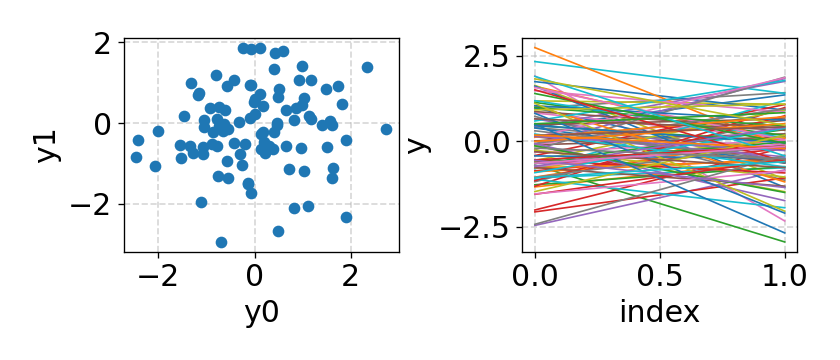

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [34]:
fig, (ay, ax) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('y')
ax.set_xlabel('index')

line, = ay.plot([0], [0], 'o')
ay.set_ylabel('y1')
ay.set_xlabel('y0')

@interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    [l.remove() for l in ax.lines]
    x = np.linspace(0, 1, 2)
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=100)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    line.set_data(data[:, 0], data[:, 1])
    ay.relim()
    ay.autoscale_view()
    fig.tight_layout()

<IPython.core.display.Javascript object>


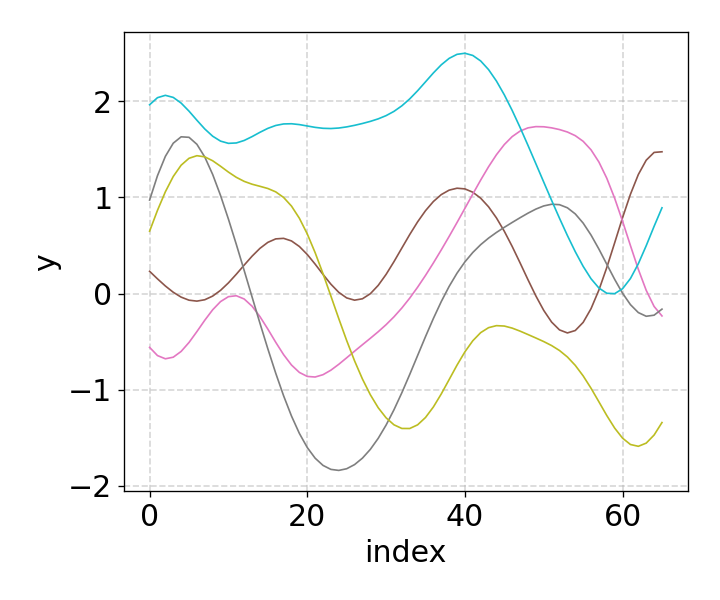

interactive(children=(FloatSlider(value=0.001, description='correlation', max=0.999, min=0.001, step=0.01), In…

In [33]:
fig, ax = mplt.subplots(1, 1, figsize=(6, 5))
ax.set_ylabel('y')
ax.set_xlabel('index')

@interact(correlation=(0.001, 0.999, 0.01), ndim=(2, 100, 1), ncurves=(1, 50, 1))
def plot_gauss(correlation=0.001, ndim=2, ncurves=5):
    [l.remove() for l in ax.lines]
    x = np.arange(ndim)
    cov = calc_cov(x, leng=2**2/2/np.sqrt(-np.log(correlation)))
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()